# "Decision intelligence from historical observations for optimal marketing resource use"
> "In this article we analyze direct marketing data and prototype a decision model to optimize future marketing uplift."
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, numpy, scikit-learn, marketing, causal inference, uplift]

# Summary

Marketing is a key success and revenue driver in B2C markets: An appropriate message placed at the appropriate time with a prospective customer will increase your business success.

However, marketing is also a major cost driver for businesses: Marketing efforts that are too broad, target the wrong audience, or convey the wrong message waste resources.

In the case of direct marketing via phone conversations a key cost factor is the amount of time a sales call agent spends with the prospective customer on the phone.

In this article we explore, rudimentarily, direct marketing data of a Portuguese financial institution.

We explore the relationship between call duration and success (purchase of offered financial product), and show that consideration of customer-specific factors influences how you should allocate your marketing resources.

Our prototypical analysis can be usueful in devising **data-driven marketing and sales** strategies that offer **decision intelligence** for your call agents.

# Fetch the data

For our prototype we use the openly accessible [Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

In [0]:
!wget --quiet https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

In [0]:
!unzip -oqq bank.zip

# Load Python libraries

In [0]:
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [0]:
np.random.seed(42)

In [0]:
#hide
def gv(s):
  return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

# Prepare data

The data we work with here contain a number of categorical and numerical variables. To keep our analysis and prototype simple we will focus on only a handful and remove the remainder.

In [0]:
#collapse
df = pd.read_csv('bank.csv', delimiter=';')
df['success'] = df['y']
del df['y']
df['success'] = df['success'].replace('no', 0)
df['success'] = df['success'].replace('yes', 1)
del df['education']
del df['default']
del df['housing']
del df['loan']
del df['contact']
del df['day']
del df['month']
del df['campaign']
del df['pdays']
del df['previous']
del df['poutcome']

Our tabular data set now looks as follows: Each prospective (and in some cases eventual) customer whom a call agent conversed with fills a row. On each row we have numerical variables (age, account balance, duration of sales interaction) and categorical variables (job / employment status and marital status). Our data set contains **4,521 sales interactions**.

In [67]:
df

,age,job,marital,balance,duration,success
0,30,unemployed,married,1787,79,0
1,33,services,married,4789,220,0
2,35,management,single,1350,185,0
3,30,management,married,1476,199,0
4,59,blue-collar,married,0,226,0
...,...,...,...,...,...,...
4516,33,services,married,-333,329,0
4517,57,self-employed,married,-3313,153,0
4518,57,technician,married,295,151,0
4519,28,blue-collar,married,1137,129,0


# High-level model: more is better

A blanket approach to marketing and sales may be: More resources lead to greater success.

So in the case of direct marketing on the phone we could expect that the more time we spend with a prospective customer on the phone, the bigger our success rate.

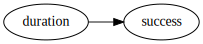

In [68]:
#hide_input
gv('''
  duration->success
''')

To test our model, we discretize the duration of our interaction with the customer into six duration buckets: bucket 1 holds the shortest interactions while bucket 6 holds the longest interactions.

In [0]:
no_buckets = 6
df['duration_bucket'] = pd.qcut(df['duration'], no_buckets, labels=[f'bucket {b + 1}' for b in range(no_buckets)])

In [201]:
df.groupby('duration_bucket').agg({'success': 'mean'})

,success
duration_bucket,
bucket 1,0.003932
bucket 2,0.031662
bucket 3,0.048193
bucket 4,0.095174
bucket 5,0.155378
bucket 6,0.358090


Looking at the average success rate in each duration bucket shows us that there is positive correlation between the duration of a sales interaction and our success rate - just as our model predicted.

Hence, more marketing spend appears to lead to greater success in general.

From a data perspective this is a pretty disappointing result as we expect to glean more intelligent insights from all the data we collected.

# Nuanced model: more isn't always better and there are always tradeoffs

Let's dig deeper into what is going on here: Yes, the duration of the interaction between call agent and prospective customer likely influences our success rate.

However, call agents also probably choose to spend more time on the phone with customers whose account balance is higher - hoping for a greater chance of a sale. That same account balance also likely influences how affine the customer is for spending more money on financial products.

Both present job status and marital status are also likely candidates for influencing an affinity for financial products.

And age of the customer probably influences both their job and marital status.

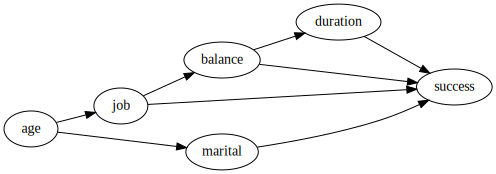

In [202]:
#hide_input
gv('''
  age->job;
  age->marital;
  job->balance;
  balance->duration;
  marital->success;
  job->success;
  balance->success;
  duration->success
''')

Since a customer's account balance probably influences both how much time we spend with them on the phone and their likelihood of purchasing another financial product we will **control for account balance**.

We control for account balance by training a cluster algorithm that segments our data set into three groups of similar account balance.

In [0]:
df['job'] = LabelEncoder().fit_transform(df['job'])
df['marital'] = LabelEncoder().fit_transform(df['marital'])

In [0]:
segmenter = KMeans(n_clusters=3, random_state=42)

In [0]:
df['segment'] = segmenter.fit_predict(df[['balance']])

In [0]:
df['segment'] = df['segment'].replace({0: 'low balance', 1: 'high balance', 2: 'medium balance'})

Looking at both the average account balance and age in our three segments, we notice that our clustering algorithm picked out low, medium, and high balance segments.

We also notice that average age correlates with average balance in these three segments hence our intuition codified in our above model seems valid.

In [225]:
df.groupby('segment').agg({'age': 'mean', 'balance': 'mean'})

,age,balance
segment,,
high balance,44.542857,18361.771429
low balance,40.845577,543.930678
medium balance,42.911111,5202.864957


Now, what about the effectiveness of our marketing resources in each segment?

Visualizing our rate of success in the six duration buckets broken down by account balance segment we see a more nuanced picture:

- Customers with low account balances really need to be worked on and only show success rates greater than 20% in the highest duration bucket 6,
- customers with medium balances already show a greater than 20% purchase likelihood in duration bucket 4, and
- customers with high balances actually max out in duration bucket 5 and drop below a 20% success rate in bucket 6.

In [0]:
success_rates = df.groupby(['segment', 'duration_bucket']).agg({'success': 'mean'}).reset_index()

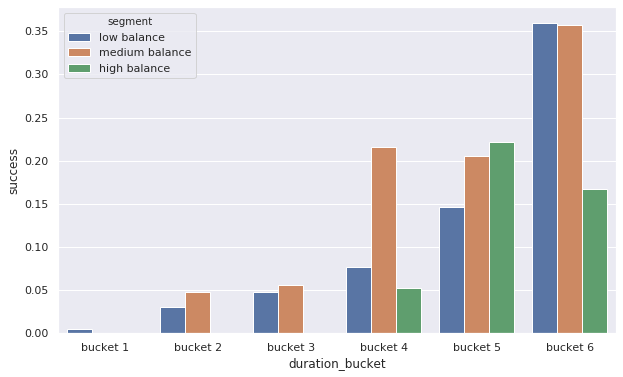

In [228]:
sns.set(rc={'figure.figsize': (10,6)})
sns.barplot(
    x='duration_bucket',
    y='success',
    hue='segment',
    data=success_rates,
    hue_order=['low balance', 'medium balance', 'high balance']
);

Our more nuanced model and analysis provide us with **data-driven insights that provide actionable and testable advice**:

- We should probably re-evaluate whether low balance individuals are sensible targets for our marketing campaigns given how resource-intensive they are,
- compute the profit and loss tradeoff between spending bucket 4 and bucket 6 resources on medium balance individuals, and
- ensure that we do not overdo it with our calls for high balance individuals.